## Pre-Req

In [25]:
!pip3 install imageio matplotlib opencv-python pandas pillow python-Levenshtein scikit-image scipy torch torchaudio torchvision torchinfo tqdm

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 KB 1.8 MB/s eta 0:00:00a 0:00:01


## Dataset structuring 

In [9]:
import os
import shutil
import re

DIR = "data/output/"
DST_DIR = "data/temp_annot/"

os.makedirs(DST_DIR,exist_ok=True)
files = os.listdir(DIR)


for f in files:
    if f.endswith('.json'):
        json_file = os.path.join(DIR,f)
        img_file = os.path.join(DIR,os.path.splitext(f)[0]+'.png')
        if os.path.isfile(img_file):
            shutil.copy(img_file,DST_DIR)
            shutil.copy(json_file,DST_DIR)

In [10]:
import json
import random
import string
import numpy as np
from PIL import Image, ImageDraw, ImageOps

os.makedirs("data/temp_annot/",exist_ok=True)
os.makedirs("data/extracted_dir/",exist_ok=True)

src_dir =  "data/temp_annot/"
dest_dir = "data/extracted_dir/"

for file in os.listdir(src_dir):
    if not file.endswith('.json'):

        img_path = os.path.join(src_dir,file)
        json_path = os.path.join(src_dir,os.path.splitext(file)[0]+'.json')

        if os.path.exists(json_path):
            with open(json_path, 'r', encoding='utf-8') as f:
                annotation = json.load(f)

            image_height = annotation['imageHeight']
            image_width = annotation['imageWidth']
            image = Image.open(img_path)


            for shape in annotation['shapes']:
                shape_type = shape['shape_type']
                group_id = shape['group_id']
                label = shape['label']
                coordinates = shape['points']
                cropped_image = Image.new('RGBA', (image_width, image_height), (0, 0, 0, 0))

                draw = ImageDraw.Draw(cropped_image)
                random_string = ''.join(random.choices(string.ascii_letters + string.digits, k=15))
                int_coordinates = [(int(point[0]), int(point[1])) for point in coordinates]
                draw.polygon(int_coordinates, fill=(255, 255, 255, 255))


                if shape_type == 'polygon':
                    mask = ImageOps.invert(cropped_image.convert('RGB'))

                    masked_image = Image.new("1", image.size)
                    masked_image.paste(image, (0, 0), mask=cropped_image)
                    bbox = masked_image.getbbox()

                    if bbox:
                        cropped_image = masked_image.crop(bbox)
                        rectangular_image = Image.new("1", (cropped_image.width, cropped_image.height), (255, 255, 255))
                        rectangular_image.paste(cropped_image, (0, 0), cropped_image)
                        new_ImageName = os.path.join(dest_dir, f"{random_string}.jpg")
                        new_LabelName = os.path.join(dest_dir, f"{random_string}.txt")
                        rectangular_image.save(new_ImageName, format='JPEG', quality=100)
                        open(new_LabelName, "w", encoding="utf-8").write(label)

                if shape_type == 'rectangle':
                    x_coordinates = [point[0] for point in int_coordinates]
                    y_coordinates = [point[1] for point in int_coordinates]
                    left = min(x_coordinates)
                    top = min(y_coordinates)
                    right = max(x_coordinates)
                    bottom = max(y_coordinates)
                    cropped_image = image.crop((left, top, right, bottom))
                    new_ImageName = os.path.join(dest_dir, f"{random_string}.jpg")
                    new_LabelName = os.path.join(dest_dir, f"{random_string}.txt")
                    cropped_image.save(new_ImageName, format='JPEG', quality=100)
                    open(new_LabelName, "w", encoding="utf-8").write(label)

# mask = ImageOps.invert(cropped_image.convert('RGB'))
# 1 (1-bit pixels, black and white, stored with one pixel per byte)
# L (8-bit pixels, grayscale)
# RGB (3x8-bit pixels, true color)
# RGBA (4x8-bit pixels, true color with transparency mask)

## Levenshtein Distance

In [1]:
def levenshtein_distance(str1, str2):
    len_str1 = len(str1) + 1
    len_str2 = len(str2) + 1

    matrix = [[0] * len_str2 for _ in range(len_str1)]

    for i in range(len_str1):
        matrix[i][0] = i
    for j in range(len_str2):
        matrix[0][j] = j

    # Calculate dist
    for i in range(1, len_str1):
        for j in range(1, len_str2):
            cost = 0 if str1[i - 1] == str2[j - 1] else 1
            matrix[i][j] = min(
                matrix[i - 1][j] + 1,  # Deletion
                matrix[i][j - 1] + 1,  # Insertion
                matrix[i - 1][j - 1] + cost,  # Substitution
            )

    return matrix[len_str1 - 1][len_str2 - 1]

## Dataset

In [2]:
import pandas as pd
import numpy as np
import os
from torch.utils.data import Dataset
from PIL import Image
import cv2

class SharadaDataset(Dataset):
    """Scripture dataset Class."""

    def __init__(self, files_dir, transform=None, char_dict=None):
        """
        Args:
            files_dir (string): Path to the txt file with labels.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """

        self.files_dir = files_dir
        self.transform = transform
        self.max_len = 0
        self.char_list = " -ँंःअआइईउऊऋऌऍऎएऐऑऒओऔकखगघङचछजझञटठडढणतथदधनऩपफबभमयरऱलळऴवशषसह़ऽािीुूृॄॅेैॉॊोौ्ॐ॒॑॓॔क़ख़ग़ज़ड़ढ़फ़य़ॠॢ।॥०१२३४५६७८९॰ॱॲॻॼॽॾ≈–|"
        if self.char_list is not None:
            chars = sorted(list(set(self.char_list)))
            self.char_dict = {c:i for i,c in enumerate(chars)}
        # print(f"Char Dict{self.char_dict}")
        self.idx_to_char = {k:v for v,k in self.char_dict.items()}
        f_ = os.listdir(self.files_dir)
        self.files = list(set([i.split('.')[0] for i in f_]))

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_name = self.files[idx] + '.jpg'
        img_filepath = os.path.join(self.files_dir,img_name)
        try:
            image = Image.open(img_filepath)

        except OSError:
            image = np.random.randint(0, 255, size=(50, 100), dtype=np.uint8)

        txt_name = self.files[idx] + '.txt'
        txt_filepath = os.path.join(self.files_dir,txt_name)
        try:
            with open(txt_filepath,'r') as file:
                label = file.read()

        except OSError:
            label = ""

        if len(label) > self.max_len:
            self.max_len = len(label)

        sample = {'image': image, 'label': label}
        # print(sample)
        if self.transform:
            sample = self.transform(sample)
        return sample

## Dataloader

In [3]:
# Dataloader Class
import torch
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

class SharadaDataLoader(object):

    def __init__(self, ds, batch_size=(16, 16), validation_split=0.2,
                 shuffle=True, seed=42, device='cpu', padding_symbol=9999):
        assert isinstance(ds, SharadaDataset)
        assert isinstance(batch_size, tuple)
        assert isinstance(validation_split, float)
        assert isinstance(shuffle, bool)
        assert isinstance(seed, int)
        assert isinstance(device, str)

        self.ds = ds
        self.batch_size = batch_size
        self.validation_split = validation_split
        self.shuffle = shuffle
        self.seed = seed
        self.device = device
        self.padding_symbol = padding_symbol

    def  __call__(self):

        dataset_size = len(self.ds)
        indices = list(range(dataset_size))
        split = int(np.floor(self.validation_split * dataset_size))

        if self.shuffle:
            np.random.seed(self.seed)
            np.random.shuffle(indices)
        train_indices, val_indices = indices[split:], indices[:split]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        # Dataloader
        train_loader = DataLoader(self.ds, batch_size=self.batch_size[0],
                                  sampler=train_sampler, collate_fn=self.collate_fn)
        validation_loader = DataLoader(self.ds, batch_size=self.batch_size[1],
                                       sampler=valid_sampler, collate_fn=self.collate_fn)

        return train_loader, validation_loader



    def collate_fn(self, batch):
        """Creates mini-batch tensors from the list of tuples (image, label).

        We should build custom collate_fn rather than using default collate_fn,
        because merging label tensor creates jagged array.
        Args:
            data: list of tuple (image, caption).
                - image: torch tensor of shape (1, 128, 32).
                - label: torch tensor of shape (?); variable length.
        Returns:
            images: torch tensor of shape (batch_size, chan_in, height, width).
            targets: torch tensor of shape (sum(target_lengths)).
            lengths: torch tensor; length of each target label.
        """

        # Sort a data list by caption length (descending order).
        #sample.sort(key=lambda x: len(x[1]), reverse=True)
        images, labels = [b.get('image') for b in batch], [b.get('label') for b in batch]

        # print(f"Collate Func: {labels}")
        # for i in images:
        #   cv2_imshow(i.permute((1, 2, 0)).cpu().numpy().astype('uint8'))

        # Merge images (from tuple of 3D tensor to 4D tensor).
        images = torch.stack(images, 0)

        # Merge captions (from tuple of 1D tensor to 2D tensor).
        lengths = [len(label) for label in labels]

        _label = [] # List of tensors with variable lengths


        for i, label in enumerate(labels):
            label_ = [self.ds.char_dict.get(letter) for letter in label] # Temporary encoded label
            _label.append(torch.tensor(label_))

        targets = nn.utils.rnn.pad_sequence(
            sequences=_label,
            batch_first=True,
            padding_value=int(self.padding_symbol),
        )
        # print(f"Targets: {targets}, Targets Shape: {targets.shape}")


        # max_label_len = max(lengths)
        # # max_label_len = 150
        # targets = []
        # for j, label in enumerate(labels):
        #   temp = [self.ds.char_dict.get(letter) for letter in label]
        #   # print(f"Label: {label}, Temp: {temp}")
        #   temp.extend([self.padding_symbol] * (max_label_len - len(label)))
        #   targets.append(torch.tensor(temp))
        #   # targets.append([torch.tensor([self.ds.char_dict.get(letter) for letter in label]).long()])

        # targets = torch.stack(targets, 0)

        # print(f" Targets Shape {targets.shape}")
        lengths = torch.tensor(lengths)

        if self.device == 'cpu':
            dev = torch.device('cpu')
        else:
            dev = torch.device('cuda')

        return images.to(dev), targets.to(dev), lengths.to(dev)

## Model

In [4]:
import torch
from torch import nn
from torch.nn import functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=False)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.downsample(identity)
        out = self.relu(out)
        return out

class CNN(nn.Module):
    def __init__(self, input_channels, hidden_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=False)
        self.resblocks = nn.Sequential(
            ResidualBlock(64, 64),
            ResidualBlock(64, 128, stride=2),
            ResidualBlock(128, 256, stride=2)
        )
        self.conv2 = nn.Conv2d(256, hidden_size, kernel_size=1, stride=1, padding=0, bias=False)
        self.pool = nn.AdaptiveAvgPool2d((1, None))

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.resblocks(x)
        x = self.conv2(x)
        x = self.pool(x)
        return x

# class CNN(nn.Module):
#   def __init__(self,input_channels, hidden_size):
#     super(CNN, self).__init__()
#     self.cnn = nn.Sequential(
#         nn.Conv2d(input_channels, 64, kernel_size=(3,3), stride=1, padding=1),
#         # nn.ReLU(inplace=False),
#         nn.MaxPool2d(kernel_size=(2,2)<<),
#         nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(inplace=False),
#         nn.MaxPool2d(2, 2),
#         nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(inplace=False),
#         nn.BatchNorm2d(256),
#         nn.MaxPool2d(2, 2),
#         nn.Conv2d(256, hidden_size, kernel_size=3, stride=1, padding=1),
#         nn.ReLU(inplace=False),
#         nn.AdaptiveAvgPool2d((1, None))
#     )
#   def forward(self, x):
#     x = self.cnn(x)
#     return x

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, bidirectional=True, batch_first=True)
        self.fc = nn.Linear(hidden_size * 2, num_classes)

    def forward(self, x):
        out, _ = self.lstm(x)
        T, b, h = out.size() # T - time_steps / inp_len
        # print(out.size())
        # out = self.fc(out[:, -1, :])

        t_rec = out.reshape(T * b, h)
        out = self.fc(t_rec) # [T * b, nOut]
        out = out.reshape(T, b, -1)

        return out

class CRNN(nn.Module):
    def __init__(self, input_channels, hidden_size, num_layers, num_classes):
        super(CRNN, self).__init__()
        self.cnn = CNN(input_channels, hidden_size)
        self.rnn = BiLSTM(hidden_size, hidden_size, num_layers, num_classes)

    def forward(self, x):
        x = self.cnn(x)
        # print(f"Output from CNN: {x} , Output Shape {x.shape} ")
        # print("shape",x.shape)
        x = x.squeeze(2)
        # print("after squeeze", x.shape )
        x = x.permute(2, 0, 1)
        x = self.rnn(x)
        # print(f"Output from RNN: {x} , Output Shape {x.shape} ")
        x = torch.nn.functional.log_softmax(x, dim=2) # Behaves Differently when batch_first is specified https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        # print(x.shape)
        return x

## Transforms

In [5]:
# transforms
# Transform and Data Augmentation
from skimage import transform, color, filters
import cv2 as cv
import numpy as np
import torch
from torchvision.transforms import Normalize
import torchvision.transforms.functional as F

class PadResize(object):
    def __init__(self, output_size):
        assert isinstance(output_size, (tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        self.w_f, self.h_f = self.output_size
        ratio_final = self.w_f / self.h_f
        self.w, self.h = image.size
        self.ratio_current = self.w / self.h

        # check if the original and final aspect ratios are the same within a margin
        if round(self.ratio_current, 2) != round(ratio_final, 2):
            # padding to preserve aspect ratio
            hp = int(self.w/ratio_final - self.h)
            wp = int(ratio_final * self.h - self.w)

            if hp > 0 and wp < 0:
                hp = hp // 2
                image = F.pad(image, (0, hp, 0, hp), 0, "constant")
                image = F.resize(image, [self.h_f, self.w_f])
            elif wp > 0 and hp < 0:
                wp = wp // 2
                image = F.pad(image, (wp, 0, wp, 0), 0, "constant")
                image = F.resize(image, [self.h_f, self.w_f])
            else:
                image = F.resize(image,[self.h_f, self.w_f])
        else:
            image = F.resize(image,[self.h_f, self.w_f])


        return {'image': image, 'label': label}

class Deskew(object):
    """Deskew handwriting samples"""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        try:
            threshold = filters.threshold_otsu(image)
        except ValueError:
            return {'image':image, 'label':label}

        binary = image.copy() < threshold

        # array of alpha values
        alphas = np.arange(-1, 1.1, 0.25)
        alpha_res = np.array([])
        alpha_params = []

        for a in alphas:
            alpha_sum = 0
            shift_x = np.max([-a*binary.shape[0], 0])
            M = np.array([[1, a, shift_x],
                          [0,1,0]], dtype=np.float64)
            img_size = (np.int(binary.shape[1] + np.ceil(np.abs(a*binary.shape[0]))), binary.shape[0])
            alpha_params.append((M, img_size))


            img_shear = cv.warpAffine(src=binary.astype(np.uint8),
                                      M=M, dsize=img_size,
                                      flags=cv.INTER_NEAREST)

            for i in range(0, img_shear.shape[1]):
                if not np.any(img_shear[:, i]):
                    continue

                h_alpha = np.sum(img_shear[:, i])
                fgr_pos = np.where(img_shear[:, i] == 1)
                delta_y_alpha = fgr_pos[0][-1] - fgr_pos[0][0] + 1

                if h_alpha == delta_y_alpha:
                    alpha_sum += h_alpha**2

            alpha_res = np.append(alpha_res, alpha_sum)

        best_M, best_size = alpha_params[alpha_res.argmax()]
        deskewed_img = cv.warpAffine(src=image, M=best_M, dsize=best_size,
                                      flags=cv.INTER_LINEAR,
                                      borderMode=cv.BORDER_CONSTANT,
                                      borderValue=255)

        return {'image':deskewed_img, 'label':label}

class toRGB(object):
    """Convert the ndarrys to RGB tensors.
       Required if using ImageNet pretrained Resnet."""

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = color.gray2rgb(image)

        return {'image': image, 'label': label}

class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __init__(self, rgb=True):
        assert isinstance(rgb, bool)
        self.rgb = rgb

    def __call__(self, sample):
        image, label = sample['image'], sample['label']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = F.to_tensor(image)
        return {'image': image, 'label': label}

class Grayscale(object):
    """Convert image to grayscale."""

    def __init__(self, num_output_channels=1):
        self.channels = num_output_channels

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        image = F.rgb_to_grayscale(image, num_output_channels=self.channels)
        return {'image': image, 'label': label}

class Normalize_Cust(object):
    """Normalise by channel mean and std"""

    def __init__(self, mean, std):
        self.mean = torch.tensor(mean, dtype=torch.float)
        self.std = torch.tensor(std, dtype=torch.float)
        self.norm = Normalize(mean, std)

    def __call__(self, sample):
        image, label = sample['image'], sample['label']
        return {'image': self.norm(image), 'label': label}

## Learner

In [6]:
import torch
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
from skimage.color import rgb2gray
from skimage.transform import rotate
import matplotlib.pyplot as plt
from torch.optim import Adam
from torch.utils.tensorboard import SummaryWriter
from torchvision.transforms import Compose
from torchvision import transforms
from tqdm import tqdm

# from utils import *
# from dataset import SharadaDataset
# from dataloader import SharadaDataLoader
# from transforms import PadResize, Deskew, toRGB, ToTensor, Normalize_Cust

os.makedirs("chk_pts/", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

batch_size = (128,64)

dataset = SharadaDataset(files_dir='data/extracted_dir/',
                        transform=Compose([
                            # Deslant(),
                            Grayscale(num_output_channels=1),
                            PadResize(output_size=(200,64)),
                            ToTensor(), # converted to Tensor
                            # Normalize_Cust(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
                            Normalize_Cust(mean=[0],std=[1])
                        ]))

# dataset = DevDataset(images,
#                         labels,
#                         transform=Compose([
#                             # Deslant(),
#                             PadResize(output_size=(64,200)),
#                             ToTensor(), # converted to Tensor
#                             Normalize_Cust(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
#                         ]))

dl = SharadaDataLoader(dataset,
                       batch_size=batch_size,
                       validation_split=0.2,
                       shuffle=False,
                       seed=3407,
                       device=str(device),
                       padding_symbol=0)

crnn_model = CRNN(input_channels=1, hidden_size=512, num_layers=2, num_classes=len(dataset.char_dict) + 1).to(device) # num_class has to be char_dict + 1 due to CTC loss
optimizer = Adam(crnn_model.parameters(), lr=0.001)

ctc_loss = nn.CTCLoss(blank=0, reduction='mean', zero_infinity=True)

cuda


In [7]:
print(crnn_model)

CRNN(
  (cnn): CNN(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (resblocks): Sequential(
      (0): ResidualBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential()
      )
      (1): ResidualBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU()
        (conv2): Conv2d(128, 128, kern

In [8]:
from torchinfo import summary
summary(crnn_model, (100, 1, 64, 64))

Layer (type:depth-idx)                        Output Shape              Param #
CRNN                                          [16, 100, 113]            --
├─CNN: 1-1                                    [100, 512, 1, 16]         --
│    └─Conv2d: 2-1                            [100, 64, 64, 64]         576
│    └─BatchNorm2d: 2-2                       [100, 64, 64, 64]         128
│    └─ReLU: 2-3                              [100, 64, 64, 64]         --
│    └─Sequential: 2-4                        [100, 256, 16, 16]        --
│    │    └─ResidualBlock: 3-1                [100, 64, 64, 64]         73,984
│    │    └─ResidualBlock: 3-2                [100, 128, 32, 32]        230,144
│    │    └─ResidualBlock: 3-3                [100, 256, 16, 16]        919,040
│    └─Conv2d: 2-5                            [100, 512, 16, 16]        131,072
│    └─AdaptiveAvgPool2d: 2-6                 [100, 512, 1, 16]         --
├─BiLSTM: 1-2                                 [16, 100, 113]            --

In [9]:
train_loader, val_loader = dl()

## Visualize

Image Shape: torch.Size([128, 1, 64, 200]), Label Shape: torch.Size([128, 63]),  Label Lengths: tensor([33, 34, 34, 24, 34,  9, 46, 50, 40, 33, 33, 31, 38, 39, 53, 35, 36, 32,
        50, 21, 35, 28, 40, 34, 37, 44, 30, 49, 50, 32, 40, 49, 32, 37, 33, 50,
        34, 35, 29, 39, 13, 22, 55, 42, 39, 40, 53, 40, 53, 39, 20, 26, 32, 55,
        11, 30, 32, 23, 51, 30, 30, 38, 33, 35, 49, 34, 37, 41, 49, 35, 34, 39,
        35, 47, 44, 31, 35, 10, 49, 25, 15, 19, 33,  8, 36, 23, 36, 38, 55, 51,
        38, 31, 33, 55, 36, 32, 62,  8, 15, 37, 56, 37,  7, 11, 41, 19, 63,  8,
        33, 36, 30, 41, 32, 27, 44,  2, 35, 19, 36, 54,  9, 34, 58, 56, 31, 34,
        38, 34], device='cuda:0')
Label: tensor([22, 75, 56,  0, 49,  0, 22, 75, 56,  0, 57, 61,  0, 47, 75,  0,  0,  0,
        54,  0, 57, 65,  0, 41, 61,  4,  0, 43, 61,  0, 54,  0, 22,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0], device='cuda:0')
M

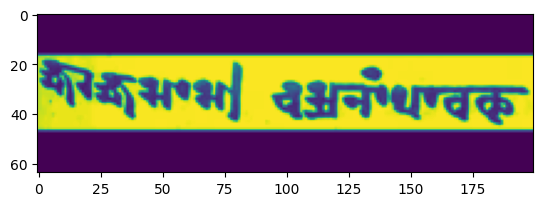

In [10]:
import matplotlib.pyplot as plt
data = next(iter(train_loader))
img, label_, label_len = data
print(f"Image Shape: {img.shape}, Label Shape: {label_.shape},  Label Lengths: {label_len}")
print(f"Label: {label_[0]}")
label_ = "".join([dataset.idx_to_char.get(c) for c in label_[0].cpu().numpy() if c!=-1])
# print(f"Image : {img}, Label : {label_}")
print(f"Maximum: {torch.max(img[0])}, Minimum: {torch.min(img[0])}")
print(f"Label : {label_}")

image = img[0].permute((1, 2, 0)).cpu()

len_ = label_len[0]
plt.imshow(image)

In [11]:
torch.autograd.set_detect_anomaly(True)

## Train Loop

In [12]:
writer = SummaryWriter()
num_epochs = 50

# Training loop
for epoch in tqdm(range(num_epochs), desc='Training'):
    crnn_model.train()
    total_loss = 0.0
    tot_correct_tr = 0
    tot_samples_tr = 0
    i = 0
    for images, targets, target_lengths in train_loader:
        print("Batch No.",i)
        images = images.to(device)
        targets = targets.to(device) # Targets is [Batch, LongestSeqLen] (N,S) -> Targets should not be blanks
        

        # print(f"images: {images.shape}, Targets: {targets.shape}, lengths: {target_lengths.shape} ")

        logits = crnn_model(images) # Outputs should be [TimeStep, Batch, NumClass]
        # (T,N,C) or (T,C) where C = number of characters in alphabet including blank, T = input length, and N = batch size.

        _, predicted_labels = torch.max(logits, 2)
        preds = ["".join([dataset.char_list[c] for c in row if c != 0]) for row in predicted_labels.cpu().numpy()]
        target_labels = ["".join([dataset.char_list[c] for c in row if c != 0]) for row in targets.cpu().numpy()]
        correct = sum(pred == target for pred, target in zip(preds, target_labels))
        tot_correct_tr += correct
        tot_samples_tr += targets.size(0)


        # logits = torch.nn.functional.log_softmax(logits, dim=2)
        logit_lengths = torch.LongTensor([logits.size(0)] * logits.size(1))
        # [BatchSize] (N) Each must be <= T

        # logits = logits.transpose(0, 1)

        # print(f"LOGIT SHAPE {logits.shape} , TARGETS SHAPE {targets.shape}")
        # print(f" Logit Lengths : {logit_lengths.shape}  Target : {target_lengths.shape}")
        # print("__________________________________________________________________________")

        # Calculate the CTC loss
        loss = ctc_loss(logits, targets, logit_lengths, target_lengths)

        # print(loss.item())
        i += 1

        loss.backward()
        torch.nn.utils.clip_grad_norm_(crnn_model.parameters(), 5.0)
        optimizer.step()
        optimizer.zero_grad()


        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    accuracy = tot_correct_tr / tot_samples_tr
    writer.add_scalar('Loss/Train', avg_loss, epoch)
    writer.add_scalar('Accuracy/Train', accuracy, epoch)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}')
    
    # Validation
    if (epoch + 1) % 1 == 0:
        crnn_model.eval()
        val_loss = 0.0
        val_tot_correct = 0
        val_tot_samples = 0

        with torch.no_grad():
            for val_images, val_targets, val_target_lengths in val_loader:
                val_images = val_images.to(device)
                # print(val_targets)
                val_targets = val_targets.to(device)
                val_tot_samples += val_targets.size(0)

                val_logits = crnn_model(val_images)
                # print(f"ValLog Before Softmax {val_logits}")
                val_logit_lengths = torch.LongTensor([val_logits.size(0)] * val_logits.size(1))

                # val_logits = torch.nn.functional.log_softmax(val_logits, dim=2)
                val_loss += ctc_loss(val_logits, val_targets, val_logit_lengths, val_target_lengths).item()
                # print(f"Val Logits {val_logits} , ValLog Shape {val_logits.shape}")

                _, predicted_labels = torch.max(val_logits, 2)
                # print(f"Before decoding : {predicted_labels} , PredLabel Shape {predicted_labels.shape}")
                preds = ["".join([dataset.char_list[c] for c in row if c != 0]) for row in predicted_labels.cpu().numpy()]
                val_target_labels = ["".join([dataset.char_list[c] for c in row if c != 0]) for row in val_targets.cpu().numpy()]
                correct = sum(pred == target for pred, target in zip(preds, val_target_labels))
                val_tot_correct += correct                
                # print(predicted_labels)

                for pred, target in zip(predicted_labels, val_targets.cpu().numpy()):
                    # print(pred)
                    distance = levenshtein_distance(pred, "".join([dataset.char_list[c] for c in target if c != 0]))
                    writer.add_scalar('LevenshteinDistance/Validation', distance, epoch)

        avg_val_loss = val_loss / len(val_loader)
        val_accuracy = val_tot_correct / val_tot_samples 
        writer.add_scalar('Loss/Validation', avg_val_loss, epoch)
        writer.add_scalar('Accuracy/Validation', val_accuracy, epoch)
        crnn_model.train()

        print(f'Validation Loss: {avg_val_loss:.4f}')

torch.save(crnn_model.state_dict(), 'chk_pts/crnn_model.pth')
writer.close()

Training:   0%|          | 0/50 [00:00<?, ?it/s]

Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [1/50], Loss: 3.0594, Accuracy: 0.0000


Training:   2%|▏         | 1/50 [00:08<07:06,  8.71s/it]

Validation Loss: 2.1228
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [2/50], Loss: 2.1483, Accuracy: 0.0000


Training:   4%|▍         | 2/50 [00:17<06:52,  8.59s/it]

Validation Loss: 2.1004
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [3/50], Loss: 2.1086, Accuracy: 0.0000


Training:   6%|▌         | 3/50 [00:25<06:43,  8.58s/it]

Validation Loss: 2.0951
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [4/50], Loss: 2.0439, Accuracy: 0.0000


Training:   8%|▊         | 4/50 [00:34<06:33,  8.55s/it]

Validation Loss: 2.2098
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [5/50], Loss: 2.0100, Accuracy: 0.0000


Training:  10%|█         | 5/50 [00:42<06:23,  8.52s/it]

Validation Loss: 2.3620
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [6/50], Loss: 1.9834, Accuracy: 0.0000


Training:  12%|█▏        | 6/50 [00:51<06:13,  8.50s/it]

Validation Loss: 2.5073
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [7/50], Loss: 1.9731, Accuracy: 0.0000


Training:  14%|█▍        | 7/50 [00:59<06:05,  8.51s/it]

Validation Loss: 2.0884
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [8/50], Loss: 1.9585, Accuracy: 0.0000


Training:  16%|█▌        | 8/50 [01:08<05:56,  8.49s/it]

Validation Loss: 2.7528
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [9/50], Loss: 1.9491, Accuracy: 0.0000


Training:  18%|█▊        | 9/50 [01:16<05:51,  8.57s/it]

Validation Loss: 1.9674
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [10/50], Loss: 1.9378, Accuracy: 0.0000


Training:  20%|██        | 10/50 [01:25<05:41,  8.53s/it]

Validation Loss: 1.9737
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [11/50], Loss: 1.9274, Accuracy: 0.0000


Training:  22%|██▏       | 11/50 [01:33<05:31,  8.49s/it]

Validation Loss: 1.9974
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [12/50], Loss: 1.9222, Accuracy: 0.0000


Training:  24%|██▍       | 12/50 [01:42<05:23,  8.51s/it]

Validation Loss: 1.9590
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [13/50], Loss: 1.9130, Accuracy: 0.0000


Training:  26%|██▌       | 13/50 [01:50<05:14,  8.49s/it]

Validation Loss: 1.9777
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [14/50], Loss: 1.8939, Accuracy: 0.0000


Training:  28%|██▊       | 14/50 [01:59<05:05,  8.47s/it]

Validation Loss: 1.9954
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [15/50], Loss: 1.8825, Accuracy: 0.0000


Training:  30%|███       | 15/50 [02:07<04:56,  8.46s/it]

Validation Loss: 2.2357
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [16/50], Loss: 1.8761, Accuracy: 0.0000


Training:  32%|███▏      | 16/50 [02:16<04:47,  8.46s/it]

Validation Loss: 1.8712
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [17/50], Loss: 1.8671, Accuracy: 0.0000


Training:  34%|███▍      | 17/50 [02:24<04:39,  8.47s/it]

Validation Loss: 1.9948
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [18/50], Loss: 1.8751, Accuracy: 0.0000


Training:  36%|███▌      | 18/50 [02:33<04:31,  8.49s/it]

Validation Loss: 1.9772
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [19/50], Loss: 1.8601, Accuracy: 0.0000


Training:  38%|███▊      | 19/50 [02:41<04:22,  8.48s/it]

Validation Loss: 2.2528
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [20/50], Loss: 1.8481, Accuracy: 0.0000


Training:  40%|████      | 20/50 [02:50<04:13,  8.47s/it]

Validation Loss: 1.8502
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [21/50], Loss: 1.8282, Accuracy: 0.0000


Training:  42%|████▏     | 21/50 [02:58<04:05,  8.45s/it]

Validation Loss: 1.9157
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [22/50], Loss: 1.8142, Accuracy: 0.0000


Training:  44%|████▍     | 22/50 [03:06<03:56,  8.45s/it]

Validation Loss: 2.8628
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [23/50], Loss: 1.8165, Accuracy: 0.0000


Training:  46%|████▌     | 23/50 [03:15<03:49,  8.50s/it]

Validation Loss: 1.8342
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [24/50], Loss: 1.8009, Accuracy: 0.0000


Training:  48%|████▊     | 24/50 [03:23<03:40,  8.49s/it]

Validation Loss: 4.1638
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [25/50], Loss: 1.7803, Accuracy: 0.0000


Training:  50%|█████     | 25/50 [03:32<03:32,  8.49s/it]

Validation Loss: 1.8648
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [26/50], Loss: 1.7456, Accuracy: 0.0000


Training:  52%|█████▏    | 26/50 [03:40<03:23,  8.48s/it]

Validation Loss: 1.7698
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [27/50], Loss: 1.7139, Accuracy: 0.0000


Training:  54%|█████▍    | 27/50 [03:49<03:15,  8.49s/it]

Validation Loss: 1.9494
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [28/50], Loss: 1.7094, Accuracy: 0.0000


Training:  56%|█████▌    | 28/50 [03:58<03:07,  8.53s/it]

Validation Loss: 3.2993
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [29/50], Loss: 1.6927, Accuracy: 0.0000


Training:  58%|█████▊    | 29/50 [04:06<02:58,  8.50s/it]

Validation Loss: 1.7348
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [30/50], Loss: 1.6626, Accuracy: 0.0000


Training:  60%|██████    | 30/50 [04:14<02:49,  8.50s/it]

Validation Loss: 1.6978
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [31/50], Loss: 1.6247, Accuracy: 0.0000


Training:  62%|██████▏   | 31/50 [04:23<02:41,  8.52s/it]

Validation Loss: 1.7006
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [32/50], Loss: 1.5964, Accuracy: 0.0000


Training:  64%|██████▍   | 32/50 [04:32<02:33,  8.55s/it]

Validation Loss: 1.6389
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [33/50], Loss: 1.6051, Accuracy: 0.0000


Training:  66%|██████▌   | 33/50 [04:40<02:24,  8.52s/it]

Validation Loss: 1.8681
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [34/50], Loss: 1.5660, Accuracy: 0.0000


Training:  68%|██████▊   | 34/50 [04:49<02:16,  8.55s/it]

Validation Loss: 1.6612
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [35/50], Loss: 1.5266, Accuracy: 0.0000


Training:  70%|███████   | 35/50 [04:57<02:07,  8.52s/it]

Validation Loss: 1.5707
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [36/50], Loss: 1.4873, Accuracy: 0.0000


Training:  72%|███████▏  | 36/50 [05:06<01:59,  8.51s/it]

Validation Loss: 1.5615
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [37/50], Loss: 1.4456, Accuracy: 0.0000


Training:  74%|███████▍  | 37/50 [05:14<01:50,  8.51s/it]

Validation Loss: 2.3725
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [38/50], Loss: 1.3954, Accuracy: 0.0000


Training:  76%|███████▌  | 38/50 [05:23<01:41,  8.50s/it]

Validation Loss: 1.4794
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [39/50], Loss: 1.3719, Accuracy: 0.0000


Training:  78%|███████▊  | 39/50 [05:31<01:33,  8.48s/it]

Validation Loss: 1.7396
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [40/50], Loss: 1.3192, Accuracy: 0.0000


Training:  80%|████████  | 40/50 [05:40<01:24,  8.48s/it]

Validation Loss: 1.5762
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [41/50], Loss: 1.2500, Accuracy: 0.0000


Training:  82%|████████▏ | 41/50 [05:48<01:16,  8.47s/it]

Validation Loss: 1.6338
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [42/50], Loss: 1.1972, Accuracy: 0.0000


Training:  84%|████████▍ | 42/50 [05:57<01:07,  8.47s/it]

Validation Loss: 1.6392
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [43/50], Loss: 1.1343, Accuracy: 0.0000


Training:  86%|████████▌ | 43/50 [06:05<00:59,  8.48s/it]

Validation Loss: 1.2643
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [44/50], Loss: 1.0825, Accuracy: 0.0000


Training:  88%|████████▊ | 44/50 [06:14<00:50,  8.50s/it]

Validation Loss: 1.3600
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [45/50], Loss: 1.0297, Accuracy: 0.0000


Training:  90%|█████████ | 45/50 [06:22<00:42,  8.51s/it]

Validation Loss: 1.3294
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [46/50], Loss: 0.9564, Accuracy: 0.0000


Training:  92%|█████████▏| 46/50 [06:30<00:33,  8.47s/it]

Validation Loss: 1.7129
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [47/50], Loss: 0.9279, Accuracy: 0.0000


Training:  94%|█████████▍| 47/50 [06:39<00:25,  8.46s/it]

Validation Loss: 1.1658
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [48/50], Loss: 0.8708, Accuracy: 0.0000


Training:  96%|█████████▌| 48/50 [06:47<00:16,  8.47s/it]

Validation Loss: 1.2190
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [49/50], Loss: 0.8147, Accuracy: 0.0000


Training:  98%|█████████▊| 49/50 [06:56<00:08,  8.47s/it]

Validation Loss: 1.1292
Batch No. 0
Batch No. 1
Batch No. 2
Batch No. 3
Batch No. 4
Batch No. 5
Batch No. 6
Batch No. 7
Batch No. 8
Epoch [50/50], Loss: 0.7768, Accuracy: 0.0000


Training: 100%|██████████| 50/50 [07:04<00:00,  8.50s/it]

Validation Loss: 1.1871


## Evaluation

torch.Size([1, 1, 64, 200])
Original Label: से३२श्रेयान्द्रव्यमयाद्यज्ञा
Predicted Label: षैःषॐैरिॐॐॐॐरयररिॐरॐररर


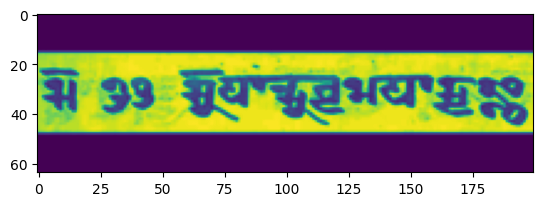

In [14]:
crnn_model.eval()
with torch.no_grad():
  data = next(iter(val_loader))
  img, label_, label_len = data
  img = img.to(device)
  print(img[0].unsqueeze(0).shape)
  label_ = label_.to(device)
  _logits = crnn_model(img[0].unsqueeze(0))
  _, predicted_labels = torch.max(_logits, 2)

  predicted_labels = "".join([dataset.char_list[c] for c in predicted_labels.flatten().cpu().numpy() if c != 0])
  # _label = "".join([dataset.idx_to_char.get(c) for c in predicted_labels.cpu().numpy() if c!=-1])


  label_ = "".join([dataset.idx_to_char.get(c) for c in label_[0].cpu().numpy() if c!=0])
  image = img[0].permute((1, 2, 0)).cpu()
  print(f"Original Label: {label_}")
  print(f"Predicted Label: {predicted_labels}")
  plt.imshow(image)